In [1]:
############## train a deep learning model via sparkdl ######################
## refer to following notebooks 
# https://docs.databricks.com/applications/deep-learning/deep-learning-pipelines.html


In [2]:
%fs ls /mnt/home/Pneumonia/chest_xray/train/

path,name,size
dbfs:/mnt/home/Pneumonia/chest_xray/train/NORMAL/,NORMAL/,0
dbfs:/mnt/home/Pneumonia/chest_xray/train/PNEUMONIA/,PNEUMONIA/,0


In [3]:
%python 
### Step 1: establish training testing set directories
import pandas as pd 
import cv2                 
import numpy as np         
import os                  
from random import shuffle
import tqdm
import scipy
import skimage
from skimage.transform import resize
print(os.listdir("/dbfs/mnt/home/Pneumonia/chest_xray/"))
TRAIN_DIR = "/dbfs/mnt/home/Pneumonia/chest_xray/train/"
TEST_DIR =  "/dbfs/mnt/home/Pneumonia/chest_xray/test/"
img_dir='/mnt/home/Pneumonia/chest_xray/'
from pyspark.ml.image import ImageSchema
image_df = ImageSchema.readImages(img_dir)
image_df.show()

In [4]:
from pyspark.ml.image import ImageSchema
from pyspark.sql.functions import lit
from sparkdl.image import imageIO
### Step 2: construct training set via pyspark.ml.image 
train_one = ImageSchema.readImages(img_dir + "/train/PNEUMONIA/").withColumn("label", lit(1))
train_two= ImageSchema.readImages(img_dir + "/train/NORMAL/").withColumn("label", lit(1))
train_df= train_one.unionAll(train_two)

## construct testing set via pyspark.ml.image
test_one = ImageSchema.readImages(img_dir + "/test/PNEUMONIA/").withColumn("label", lit(1))
test_two= ImageSchema.readImages(img_dir + "/test/NORMAL/").withColumn("label", lit(1))
test_df= test_one.unionAll(test_two)

train_df = train_df.repartition(100)
test_df=test_df.repartition(100)
train_df.show(), test_df.show()

In [5]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from sparkdl import DeepImageFeaturizer 
### Step 3: use sparkdl to create features and then use InceptionV3 as base model stack a logisitic regression model on top of it then fit the train data
featurizer = DeepImageFeaturizer(inputCol="image", outputCol="features", modelName="InceptionV3")
lr = LogisticRegression(maxIter=20, regParam=0.05, elasticNetParam=0.3, labelCol="label")
p = Pipeline(stages=[featurizer, lr])

p_model = p.fit(train_df)

In [6]:
### Step 4: make the prediction and check the performance on test_df
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
## predict on testing set and evaluate the performance
tested_df = p_model.transform(test_df)
evaluator = MulticlassClassificationEvaluator(metricName="accuracy")
print("Test set accuracy = " + str(evaluator.evaluate(tested_df.select("prediction", "label"))))

In [7]:
### Step 5: save the model to .h5
p_model.save('/dbfs/mnt/home/Pneumonia/'+'sparkdl_inceptionV3_pneumonia_model.h5')

In [8]:
### (option): check where did we did wrong
from pyspark.sql.types import DoubleType
from pyspark.sql.functions import expr
def _p1(v):
  return float(v.array[1])
p1 = udf(_p1, DoubleType())

df = tested_df.withColumn("p_1", p1(tested_df.probability))
wrong_df = df.orderBy(expr("abs(p_1 - label)"), ascending=False)
display(wrong_df.select("image.origin", "p_1", "label").limit(10))

In [9]:
""" other debugging stuff skip 
import random
rn_label=random.choice(['PNEUMONIA','NORMAL'])
test_ls=os.listdir('/dbfs/mnt/home/Pneumonia/chest_xray/test/'+rn_label+'/')
test_path='dbfs:/mnt/home/Pneumonia/chest_xray/test/'+rn_label+'/'
rn=random.randint(0,len(test_ls))
rn_sample=test_path+test_ls[rn]
rn_sample
"""

In [10]:
### Step 6: convert the prediction spark dataframe and convert to pandas dataframe 
from pyspark.sql.types import Row
x=df.select('image.origin','label','prediction').filter(col("image.origin")==rn_sample)
pdf=x.toPandas()
pdf


In [11]:
#'/dbfs'+pdf.iloc[0,0].split(':')[1]
#classes[str(int(pdf.iloc[0,-1]))]

In [12]:
### Step 7: visualize randomly selected test image as well as its prediction
import matplotlib.pyplot as plt
classes={'0':'Normal', '1':'Pneumonia'}

im=plt.imread('/dbfs'+pdf.iloc[0,0].split(':')[1])
plt.imshow(im)
plt.title("Label={} , prediction = {}".format( classes[str(int(pdf.iloc[0,-2]))],classes[str(int(pdf.iloc[0,-1]))]))
display(plt.show())

In [13]:
### (option) : visualize randomly selected test image as well as its prediction randomly visualize sample image
Pimages = os.listdir('/dbfs/mnt/home/Pneumonia/chest_xray/test/' + "PNEUMONIA")
Nimages = os.listdir('/dbfs/mnt/home/Pneumonia/chest_xray/test/' + "NORMAL")
import random
Pneumonia_img=random.choice(Pimages)
Normal_img=random.choice(Nimages)
import matplotlib.pyplot as plt
def plotter(Pneumonia_img,Normal_img):
    imagep1 = cv2.imread('/dbfs/mnt/home/Pneumonia/chest_xray/test/'+"PNEUMONIA/"+Pneumonia_img)
    imagep1 = cv2.resize(imagep1, (150, 150))
    imagen1 = cv2.imread('/dbfs/mnt/home/Pneumonia/chest_xray/test/'+"NORMAL/"+Normal_img)
    imagen1 = cv2.resize(imagen1, (150, 150))
    f = plt.figure()

    f.add_subplot(1,2, 1)
    plt.title("Penumonia")
    plt.imshow(imagep1)

    f.add_subplot(1,2, 2)
    plt.title("Normal")
    plt.imshow(imagen1)

    plt.show(block=True)

display(plotter(Pneumonia_img,Normal_img))
    
pass

In [14]:
#### another way to construct model directly from keras , noted it will be slower than utilize sparkdl deep learning libraries since it is not using parallel computing

In [15]:
#### one can also use keras native sequential to construct and train a model , as long as you save the trained model, the deployment apply the same concept
from keras.callbacks import ReduceLROnPlateau , ModelCheckpoint , LearningRateScheduler
from keras.models import Sequential , Model
from keras.layers import Dense , Activation
from keras.layers import Dropout , GlobalAveragePooling2D
from keras.layers import Flatten
from keras.constraints import maxnorm
from keras.optimizers import SGD , RMSprop , Adadelta , Adam
from keras.layers import Conv2D , BatchNormalization
from keras.layers import MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
K.set_image_dim_ordering('tf')
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
lr_reduce = ReduceLROnPlateau(monitor='val_acc', factor=0.1, min_delta=0.0001, patience=1, verbose=1)
filepath="/dbfs/mnt/home/Pneumonia/"+"transferlearning_weights.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
from keras.applications.inception_v3 import InceptionV3
# create the base pre-trained model
base_model = InceptionV3(weights=None, include_top=False , input_shape=(150, 150,3))
x = base_model.output
x = Dropout(0.5)(x)
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
predictions = Dense(2, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(loss='categorical_crossentropy', 
                  optimizer='adam', 
                  metrics=['accuracy'])
print(model.summary())

In [16]:
""" use to examine the trained model performance
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
display(plt.show())
pass
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
display(plt.show())
pass
"""

In [17]:
from sklearn.metrics import confusion_matrix
pred = model.predict(X_test)
print(pred.shape)
#pred = np.argmax(pred,axis = 1) 
pred[:10], y_test[:10]

In [18]:
############## from here onwards is model deployment via ACI and test out the web service ######################
# refer to following notebooks : 
# https://github.com/Azure/MachineLearningNotebooks/blob/master/01.getting-started/10.register-model-create-image-deploy-service/10.register-model-create-image-deploy-service.ipynb <-- for score.py + webservice
# https://github.com/Azure/MachineLearningNotebooks/tree/master/tutorials <-- for score.py + webservice construction
# https://github.com/Azure/MachineLearningNotebooks/tree/master/databricks <-- for installation of the azureml.core sdk
# use databrick cluster : AzureDB_SDK configuration + attached libaries

In [19]:
### step 1 : check azureml.core can be imported 
import azureml.core

# Check core SDK version number - based on build number of preview/master.
print("SDK version:", azureml.core.VERSION)

SDK version: 0.1.59

In [20]:
### step 2 : fill in the following in order to create workspace
subscription_id = "my_azure_subscriptionid"
resource_group = "ADFTutorialDatafactoryResourceGroup"
workspace_name = "pneumonia_ws"
workspace_region = "eastus"

In [21]:
### step 3 : create workspace, note if created earlier, can skip to step 5 
from azureml.core import Workspace

ws = Workspace.create(name = workspace_name,
                      subscription_id = subscription_id,
                      resource_group = resource_group, 
                      location = workspace_region,
                      exist_ok=True)

#ws.get_details()

Performing interactive authentication. Please follow the instructions on the terminal.
To sign in, use a web browser to open the page https://microsoft.com/devicelogin and enter the code ABA8KWX6G to authenticate.
Interactive authentication successfully completed.

In [22]:
### step 4 : construct config file to be used later , so one does not need to supply the information every time 
ws = Workspace(workspace_name = workspace_name,
               subscription_id = subscription_id,
               resource_group = resource_group)

# persist the subscription id, resource group name, and workspace name in aml_config/config.json.
ws.write_config()

Wrote the config file config.json to: /databricks/driver/aml_config/config.json

In [23]:
### step 5 : create workspace from previous saved config file
from azureml.core import Workspace
#### if you have already done the above once , then you should have a config file already, one can start from here instead of step 1
ws = Workspace.from_config()
print(ws.name, ws.resource_group, ws.location,  sep = '\n')

Found the config file in: /databricks/driver/aml_config/config.json
pneumonia_ws
ADFTutorialDatafactoryResourceGroup
eastus

In [24]:
""" ####### do not run unless want to retrain
batch_size = 64
epochs = 10
history = model.fit(X_train, y_train, validation_data = (X_test , y_test) ,callbacks=[lr_reduce,checkpoint] ,
          epochs=epochs)
"""

Out[ 8 ]: ' ####### do not run unless want to retrain\nbatch_size = 64\nepochs = 10\nhistory = model.fit(X_train, y_train, validation_data = (X_test , y_test) ,callbacks=[lr_reduce,checkpoint] ,\n epochs=epochs)\n'

In [25]:
""" check the model path is correct and the model can be correctly loaded 
from keras.models import load_model
### save entire model + weights + architect 
loaded_model.save('/dbfs/mnt/home/Pneumonia/pneumonia.h5')  # creates a HDF5 file 'my_model.h5'
del loaded_model  # deletes the existing model

# returns a compiled model
# identical to the previous one
model = load_model('/dbfs/mnt/home/Pneumonia/pneumonia.h5')
"""

In [26]:
%fs ls /mnt/home/Pneumonia/

path,name,size
dbfs:/mnt/home/Pneumonia/InceptionV3.JPG,InceptionV3.JPG,172524
dbfs:/mnt/home/Pneumonia/chest_xray/,chest_xray/,0
dbfs:/mnt/home/Pneumonia/inceptionv3.htm,inceptionv3.htm,55898
dbfs:/mnt/home/Pneumonia/model_10epochs.h5,model_10epochs.h5,88973880
dbfs:/mnt/home/Pneumonia/model_10epochs.json,model_10epochs.json,147742
dbfs:/mnt/home/Pneumonia/pneumonia.h5,pneumonia.h5,89122912
dbfs:/mnt/home/Pneumonia/transferlearning_weights.hdf5,transferlearning_weights.hdf5,265594208


In [27]:
### step 6 : loading test dataset to be used in webservice testing later on
import numpy as np
X_test=np.load("/dbfs/mnt/home/Pneumonia/chest_xray/X_test.npy")
y_test=np.load("/dbfs/mnt/home/Pneumonia/chest_xray/y_test.npy")
X_test.shape

Out[ 9 ]: (624, 150, 150, 3)

In [28]:
### step 7 : register a model
from azureml.core import Workspace
ws = Workspace.from_config()

from azureml.core.model import Model

model_name = "pnumonia_model"
model = Model.register(model_path="/dbfs/mnt/home/Pneumonia/pneumonia.h5",
                        model_name=model_name,
                        tags = {'area': "pneumonia","data": "pneumonia", 'type': "classification", "model": "classification"},
                        description="trained pneumonia model for binary classification",
                        workspace=ws)

# download test data
#import os
#import urllib.request

#os.makedirs('/dbfs/mnt/home/Pneumonia/', exist_ok=True)


Found the config file in: /databricks/driver/aml_config/config.json
Registering model pnumonia_model

In [29]:
### (option) : check everything looks oki
print(model.name, model.description, model.version, model.properties, sep = '\t')


pnumonia_model	trained pneumonia model for binary classification	4	{}

In [30]:
### step 8 : download the model to the target_dir . , assert model exists in the target_dir
from azureml.core import Workspace
from azureml.core.model import Model

ws = Workspace.from_config()
model=Model(ws, 'pnumonia_model')
model.download(target_dir = '.')
import os 
# verify the downloaded model file
## run below to verify the written config.json file info
# %sh cat /databricks/driver/aml_config/config.json 
os.stat('./pneumonia.h5')

Found the config file in: /databricks/driver/aml_config/config.json
 Out[ 12 ]: os.stat_result(st_mode=33188, st_ino=3932710, st_dev=45, st_nlink=1, st_uid=0, st_gid=0, st_size=89122912, st_atime=1537876382, st_mtime=1537876382, st_ctime=1537961040)

In [31]:
### step 9 : verified the copied to target_dir model is indeed working and can make prediction
from keras.models import load_model
loaded_pneumonia_model=load_model('./pneumonia.h5')
y_hat=loaded_pneumonia_model.predict(X_test)
y_hat=np.argmax(y_hat,axis=1)

from sklearn.metrics import confusion_matrix

conf_mx = confusion_matrix(y_test, y_hat)
print(conf_mx)
print('Overall accuracy:', np.average(y_hat==y_test))

Using TensorFlow backend.
/databricks/python/lib/python3.5/site-packages/keras/engine/saving.py:269: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
 warnings.warn('No training configuration found in save file: '
[[102 132]
 [ 0 390]]
Overall accuracy: 0.7884615384615384

In [32]:
### step 10  : create the score.py file to take in the X_test data and then score it with the registered model

In [33]:
%%writefile score.py
import json
import numpy as np
import os
from keras.models import load_model

from azureml.core.model import Model

def init():
    global model
    # retreive the path to the model file using the model name
    model_path = Model.get_model_path('pnumonia_model')
    #model_path="/dbfs/mnt/home/Pneumonia/pneumonia.h5"
    model = load_model(model_path)

def run(test_data):
  try:
    data = np.array(json.loads(test_data)['data'])
    # make prediction
    y_hat = model.predict(data)
    y_hat = np.argmax(y_hat, axis=1)
  except Exception as e:
    result = str(e)
  return json.dumps({"result":y_hat.tolist()})


Writing score.py

In [34]:
""" make sure the json parsed data can indeed be load back to numpy arrays
### (option) : make sure the data which was dumped and loaded back by json can indeed be read back as numpy array 
n = 5
## construct randomly sample indices 
sample_indices = np.random.permutation(X_test.shape[0])[0:n]

### dump the randomly select image from X_test to json 
test_samples = json.dumps({"data": X_test[sample_indices].tolist()})

#### we do not need to make it into bytes so skip this line 
#test_samples = bytes(test_samples, encoding = 'utf8')

### load the test_sample back and make sure 
data = np.array(json.loads(test_samples)['data'])

## check it is indeed in numpy array and verify the shape of the numpy array
data.shape
"""


Out[ 62 ]: (5, 150, 150, 3)

In [35]:
### step 11  : construct the conda dependency yml file , ammke sure tensorflow, keras , numpy and scikit-learn, scikit-image are all listed for installation
from azureml.core.conda_dependencies import CondaDependencies 

myenv = CondaDependencies.create(conda_packages=['numpy','scikit-learn'])
myenv.add_conda_package("tensorflow")
myenv.add_conda_package("keras")
myenv.add_conda_package("scikit-image")


with open("pneumonia_env.yml","w") as f:
    f.write(myenv.serialize_to_string())

In [36]:
with open("pneumonia_env.yml","r") as f:
    print(f.read())

# Conda environment specification. The dependencies defined in this file will
# be automatically provisioned for runs with userManagedDependencies=False.

# Details about the Conda environment file format:
# https://conda.io/docs/user-guide/tasks/manage-environments.html#create-env-file-manually

name: project_environment
dependencies:
 # The python interpreter version.
 # Currently Azure ML only supports 3.5.2 and later.
- python=3.6.2

- pip:
 - azureml-defaults==0.1.59
- numpy
- scikit-learn
- tensorflow
- keras
- scikit-image

In [37]:
### step 12  : create the image by the configuration above, given score.py and yml file 
from azureml.core.image import Image, ContainerImage

image_config = ContainerImage.image_configuration(runtime= "python",
                                 execution_script="score.py",
                                 conda_file="pneumonia_env.yml",
                                 tags = {"data": "pneumonia", "model": "classification"},
                                 description = "Binary classification model on Pneumonia dataset")

image = Image.create(name = "pneumoniaimage",
                     # this is the model object 
                     models = [model],
                     image_config = image_config, 
                     workspace = ws)

Creating image

In [38]:
### step 13  : create config file for webservice 
from azureml.core.webservice import AciWebservice

aciconfig = AciWebservice.deploy_configuration(cpu_cores=1, 
                                               memory_gb=1, 
                                               tags={"data": "pneumonia",  "method" : "keras"}, 
                                               description='trained pneumonia model for binary classification via keras + tf backend')



In [39]:
%%time
from azureml.core.webservice import Webservice
from azureml.core.image import ContainerImage
### step 14  : create the webservice 
# configure the image
image_config = ContainerImage.image_configuration(execution_script="score.py", 
                                                  runtime="python", 
                                                  conda_file="pneumonia_env.yml")

service = Webservice.deploy_from_model(workspace=ws,
                                       name='webservice-pneumonia',
                                       deployment_config=aciconfig,
                                       models=[model],
                                       image_config=image_config)

service.wait_for_deployment(show_output=True)


Creating image
Image creation operation finished for image webservice-pneumonia:3, operation "Succeeded"
Creating service
Running...................................................................
SucceededACI service creation operation finished, operation "Succeeded"
CPU times: user 4.57 s, sys: 858 ms, total: 5.43 s
Wall time: 11min 34s

In [40]:
### step 15  : check the url of the deployed webservice 
print(service.scoring_uri)

http://40.117.126.222:80/score

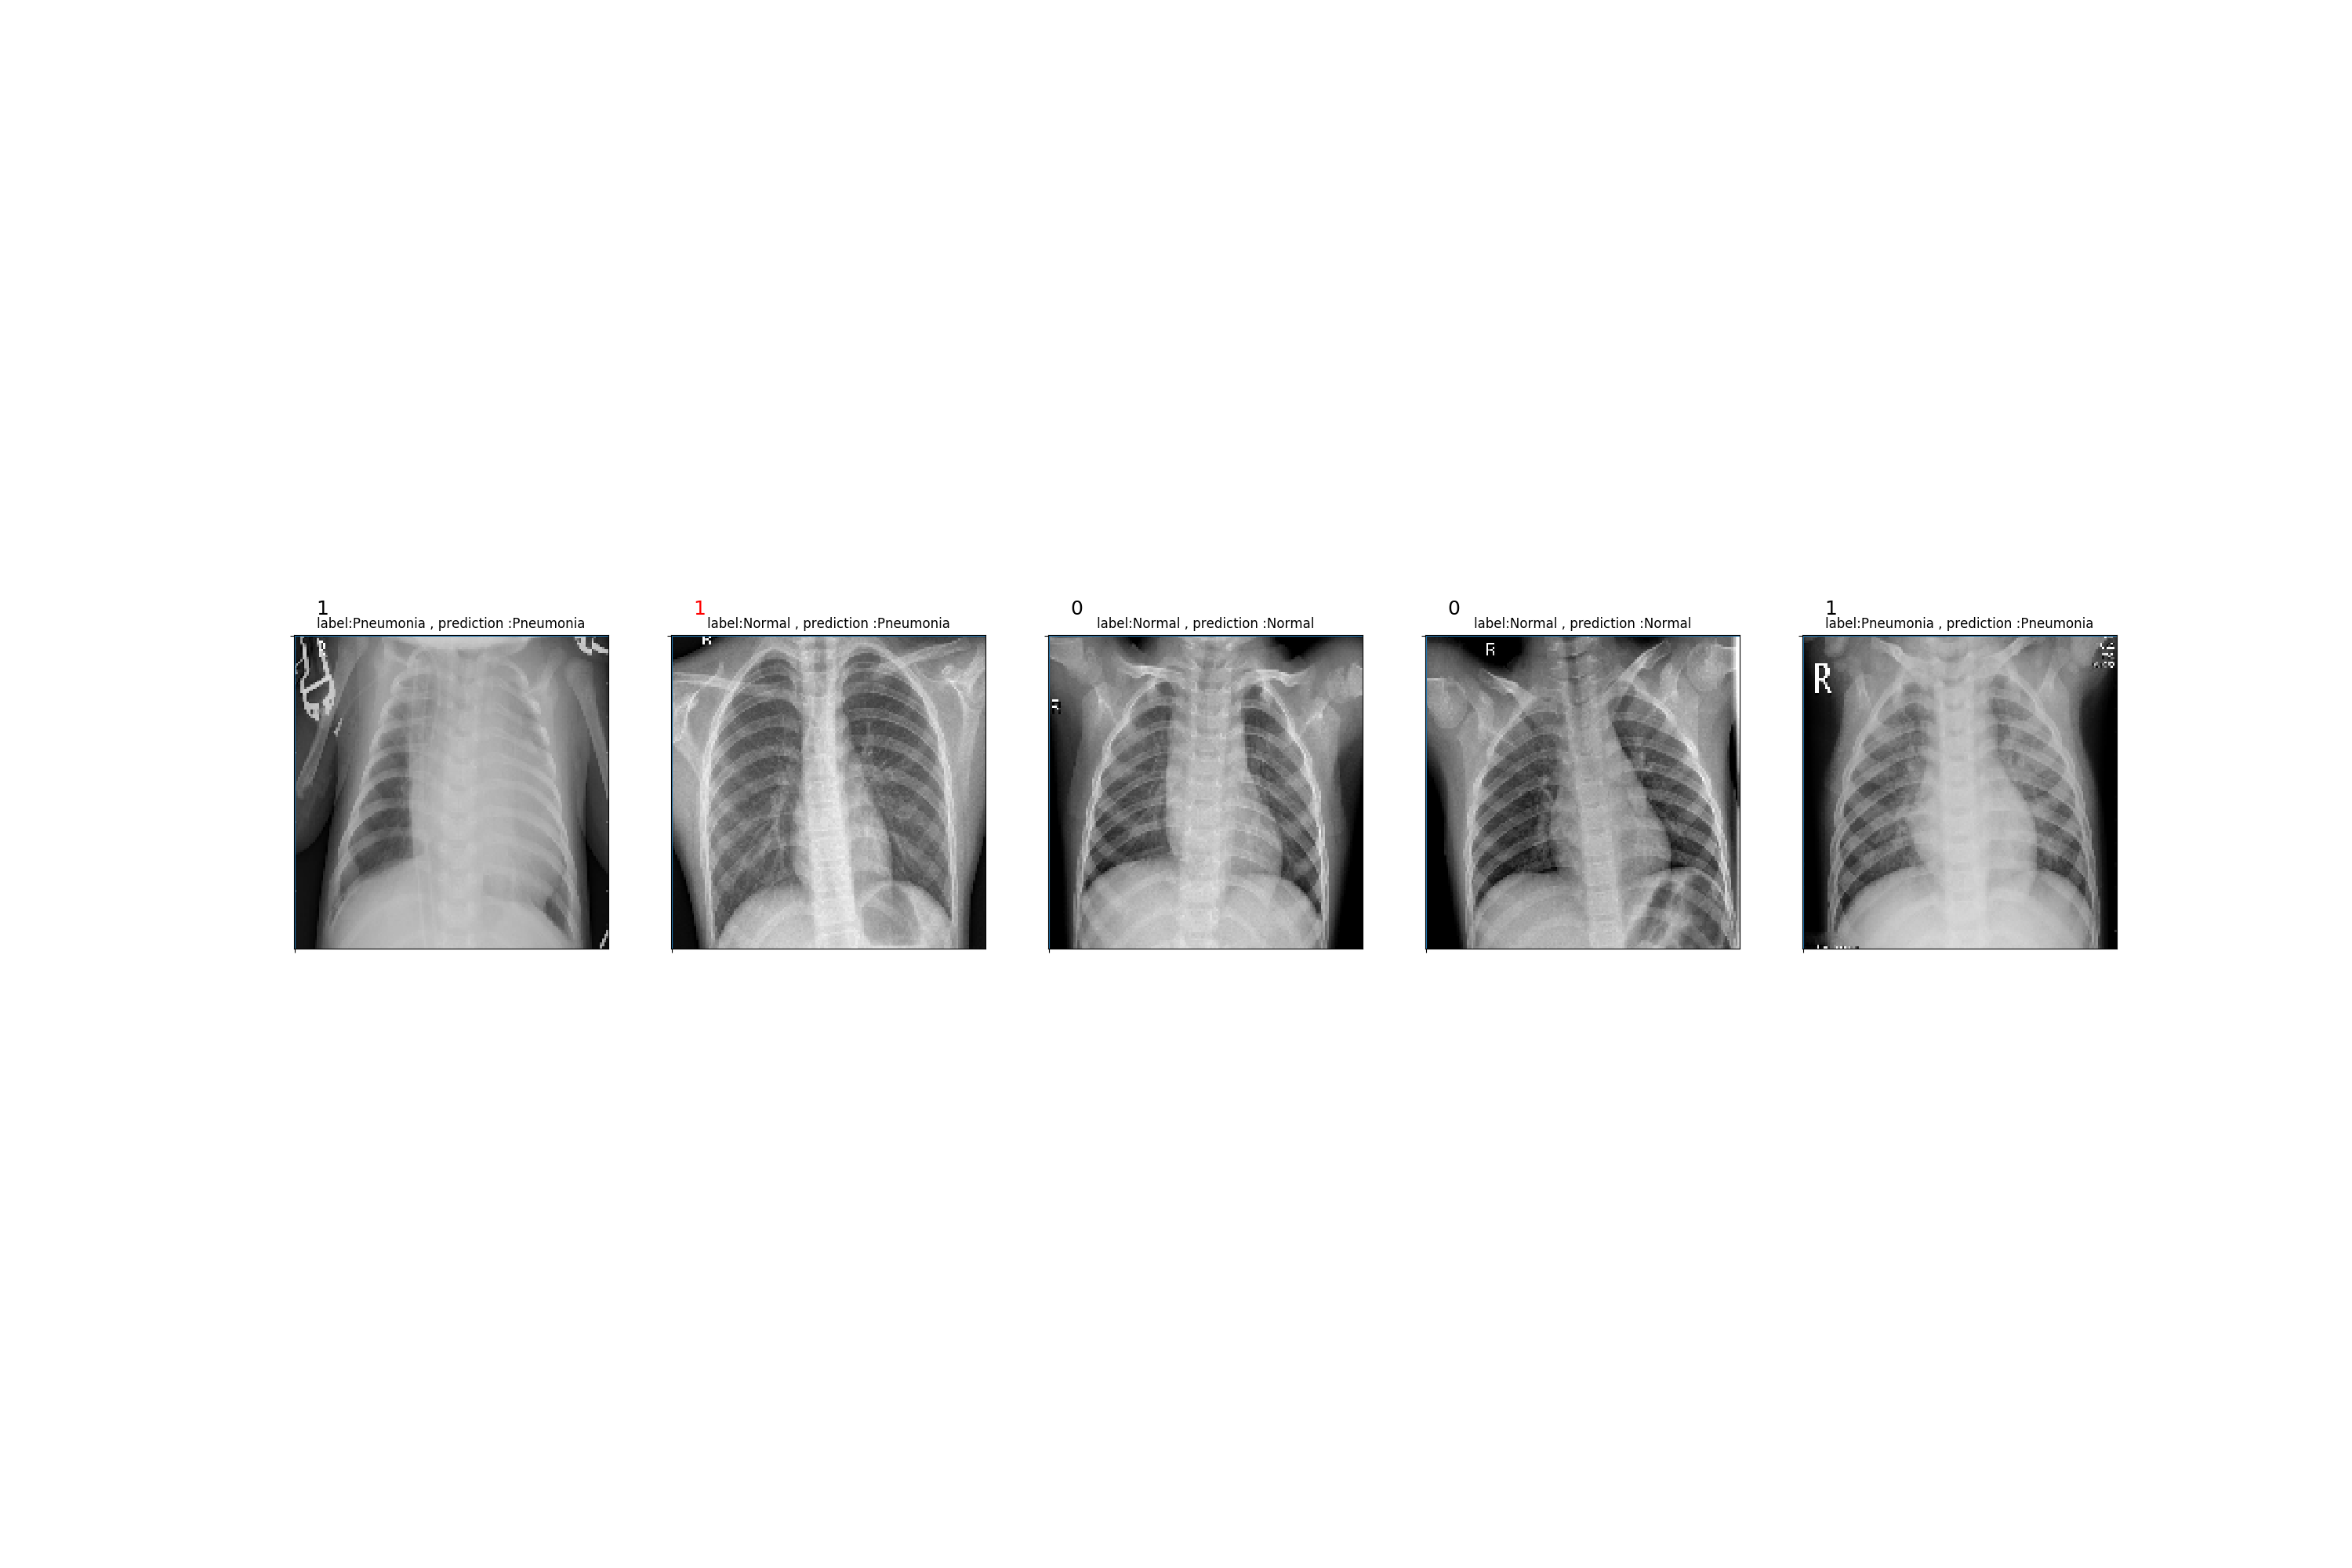

In [41]:
### step 16  : test the webservice by giving randomly selected image from X_test and get the predictions back, verify the predicted labels with the actual labels
import json

# find 30 random samples from test set
n = 5
sample_indices = np.random.permutation(X_test.shape[0])[0:n]

test_samples = json.dumps({"data": X_test[sample_indices].tolist()})
#test_samples = bytes(test_samples, encoding = 'utf8')

# predict using the deployed model
result = json.loads(service.run(input_data=test_samples))
print(result['result'])
# compare actual value vs. the predicted values:
import matplotlib.pyplot as plt
classes={1:'Pneumonia',0:'Normal'}
i = 0
plt.figure(figsize = (30, 20))
result=[int(x) for x in result['result']]
for s in sample_indices:
    plt.subplot(1, n, i + 1)
    plt.axhline('')
    plt.axvline('')
    
    # use different color for misclassified sample
    font_color = 'red' if y_test[s] != result[i] else 'black'
    clr_map = plt.cm.gray if y_test[s] != result[i] else plt.cm.Greys
    
    plt.text(x=10, y =-10, s=result[i], fontsize=18, color=font_color)
    plt.title("label:{} , prediction :{}".format(classes[int(y_test[s])], classes[int(result[i])]))
    plt.imshow(X_test[s], cmap=clr_map)
    
    i = i + 1
display(plt.show())
pass


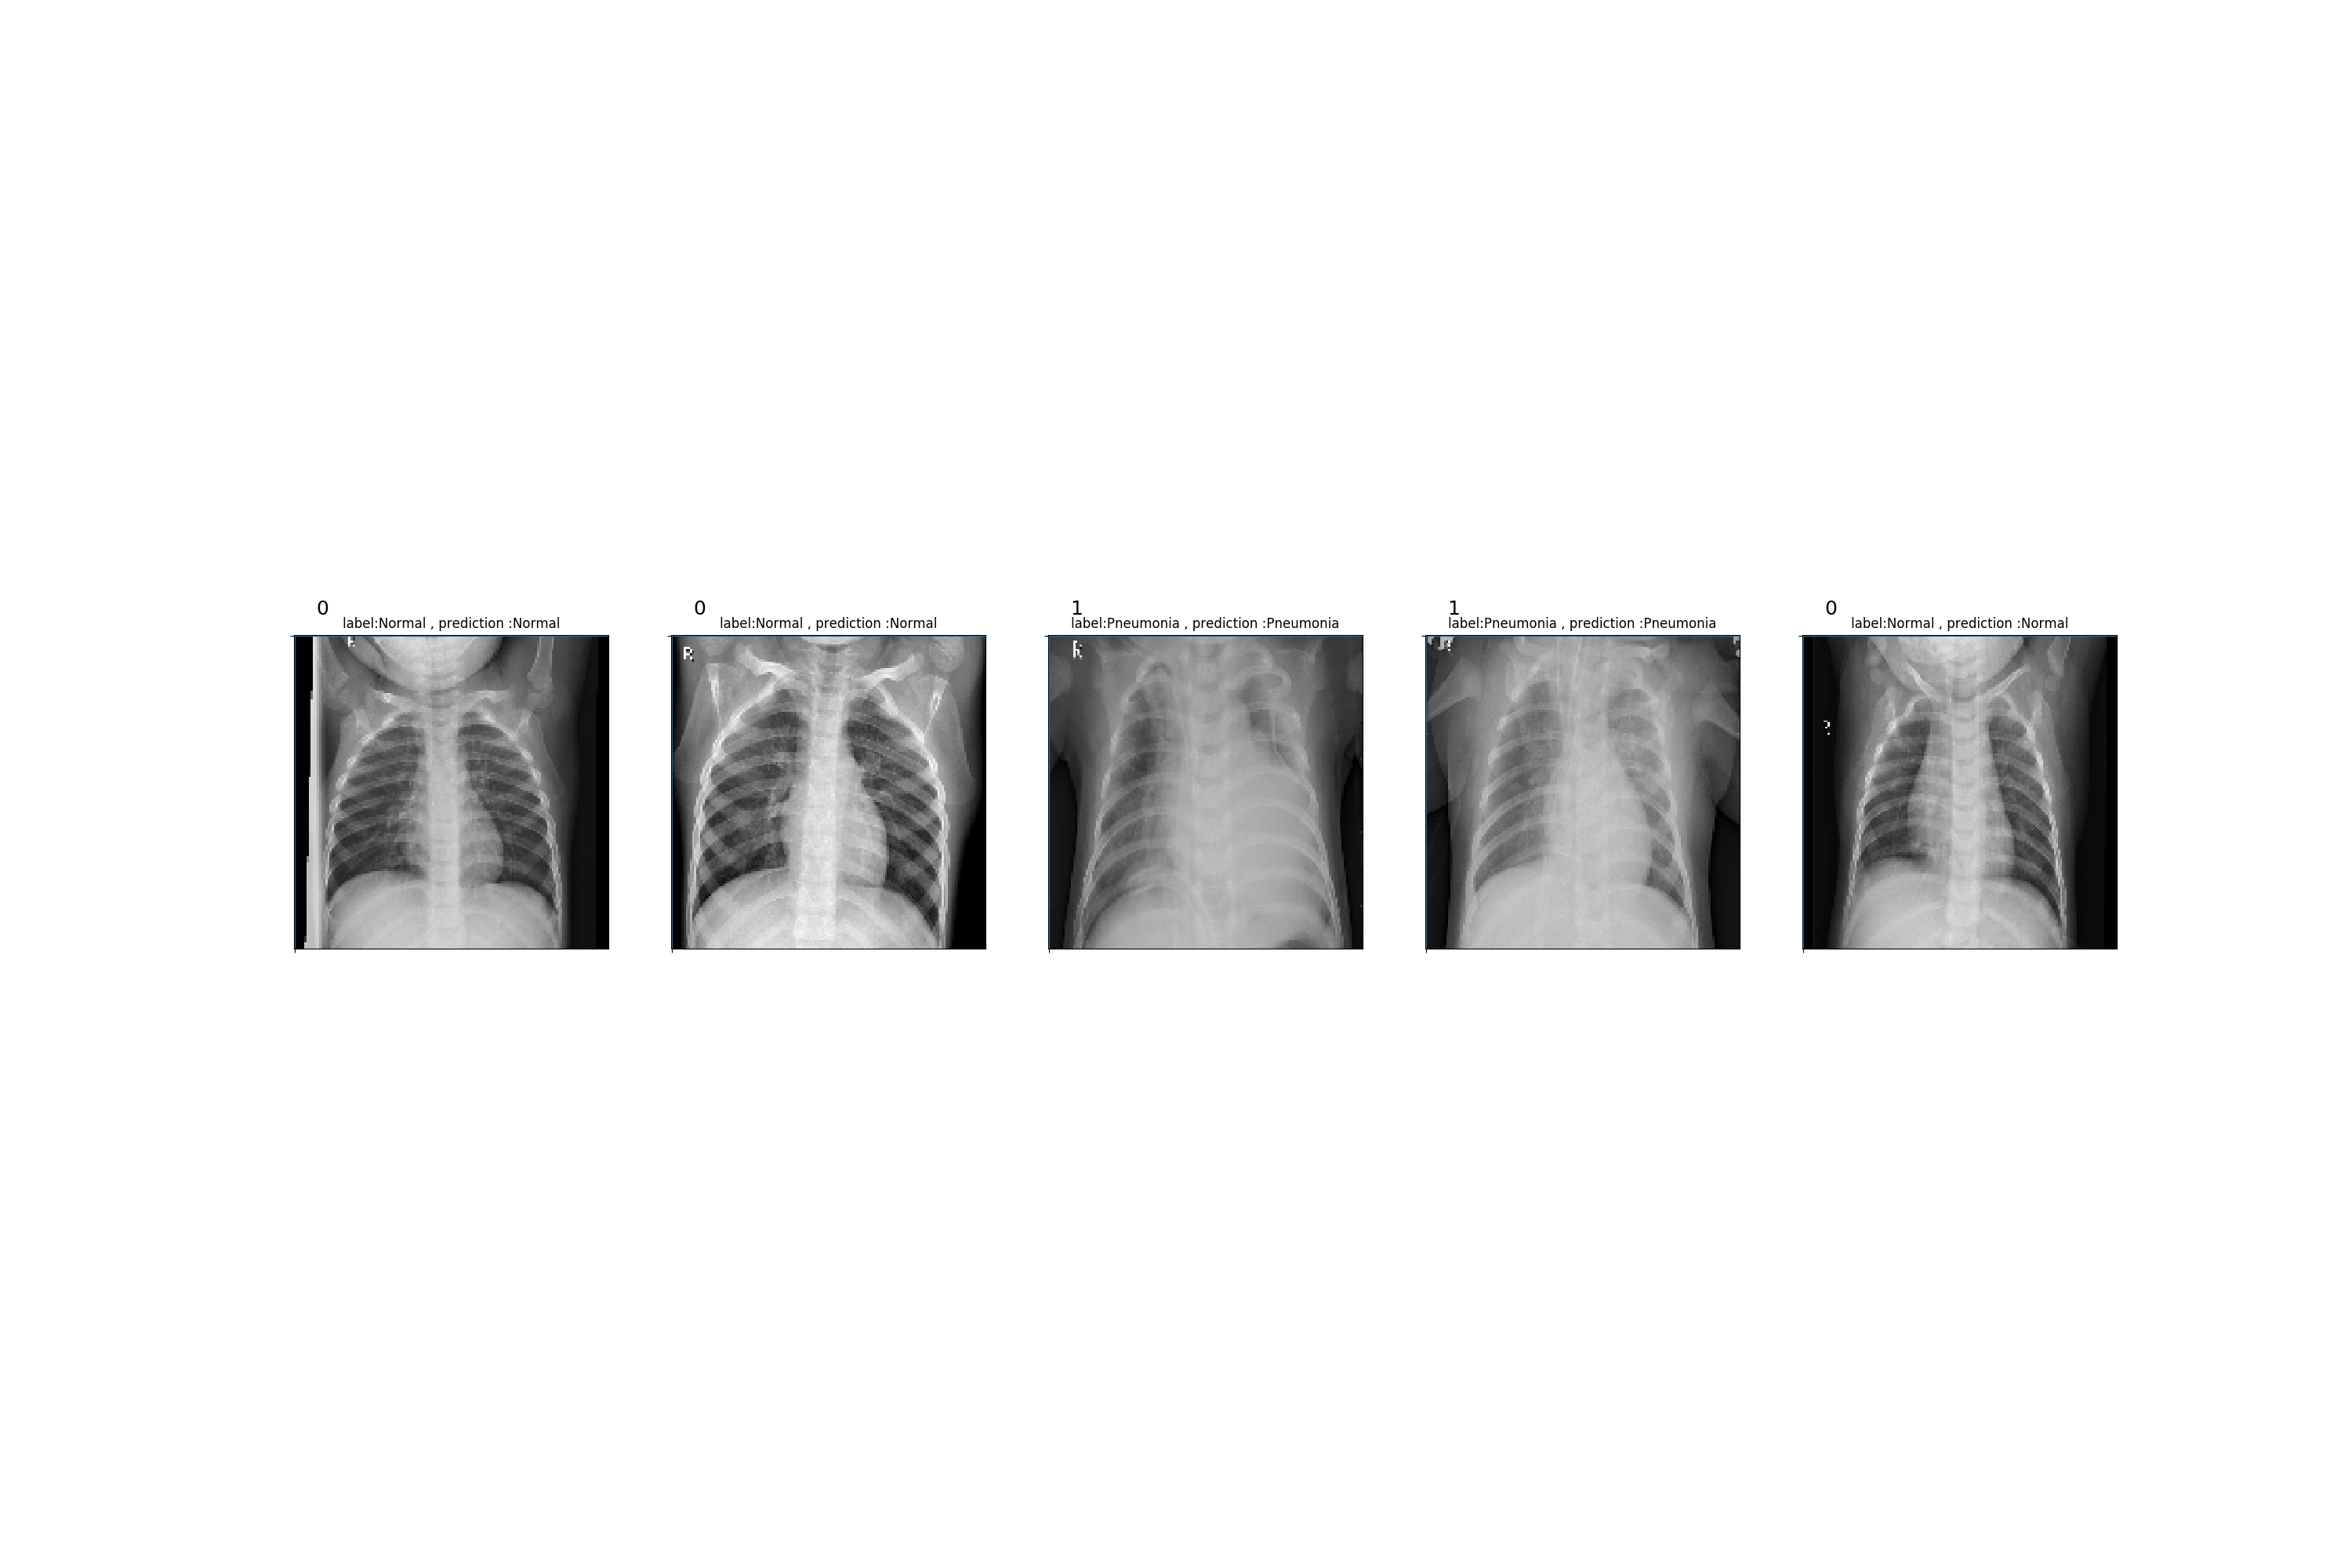

In [43]:
service.delete()